Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. CHF KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [3]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [5]:
random_states = [0, 25, 42]

## 3. Random Forest Classfier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import shap


feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []
test_proba_dic = {}

for random_state in random_states:

    # Split the data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

    # Define model
    model = RandomForestClassifier(random_state=random_state, class_weight="balanced")
    
    # Define hyperparameters for grid search
    hyperparameter_grid = {
        'n_estimators': [100, 200, 250, 300], 
        'max_depth': [None, 2, 5, 10, 15, 25], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
        }


    # Define grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=skf,
                           scoring='f1_macro')
    
    # Execute grid search
    grid_cv.fit(X_train, y_train)
    
    # Display best parameters
    display(grid_cv.best_params_)
    
    # Retrain the model with the best parameters
    model = RandomForestClassifier(random_state=random_state, 
                                   n_estimators=grid_cv.best_params_['n_estimators'], 
                                   max_depth=grid_cv.best_params_['max_depth'], 
                                   min_samples_split=grid_cv.best_params_['min_samples_split'],
                                   max_features=grid_cv.best_estimator_.max_features,
                                   class_weight="balanced",
                                   n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
     
    # Predict classes
    y_pred = model.predict(X_test)

    # Print ROC-AUC, confusion matrix, and classification report
    print(f"========== {random_state=} ==========")
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))
    print('Classification report:\n', classification_report(y_test, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test, check_additivity=False)

    shap_values_list.append(shap_values[0])
    feature_importances[random_state] = model.feature_importances_
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values[1]), axis=0)

# Calculate mean feature importances and SHAP values
feature_importances['mean_importance'] = feature_importances[random_states].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)

{'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300}

========== random_state=0 ==========
ROC-AUC: 0.8707599478147422
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       584
           1       0.21      0.14      0.17        21

    accuracy                           0.95       605
   macro avg       0.59      0.56      0.57       605
weighted avg       0.94      0.95      0.95       605

Confusion matrix:
 [[573  11]
 [ 18   3]]


 98%|===================| 1183/1210 [00:40<00:00]        

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 250}

========== random_state=25 ==========
ROC-AUC: 0.8682322243966081
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       584
           1       0.28      0.48      0.35        21

    accuracy                           0.94       605
   macro avg       0.63      0.72      0.66       605
weighted avg       0.96      0.94      0.95       605

Confusion matrix:
 [[558  26]
 [ 11  10]]


{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

========== random_state=42 ==========
ROC-AUC: 0.913894324853229
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       584
           1       0.28      0.71      0.41        21

    accuracy                           0.93       605
   macro avg       0.64      0.82      0.68       605
weighted avg       0.96      0.93      0.94       605

Confusion matrix:
 [[546  38]
 [  6  15]]


In [20]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_importance,mean_shap
Age,0.076591,0.008707,0.068596,0.017234,0.072099,0.014367,0.072428,0.013436
ОССН KiLLip,0.079567,0.018582,0.086864,0.033611,0.113217,0.033044,0.093216,0.028412
HBR (b),0.144947,0.022997,0.141003,0.025911,0.139042,0.038792,0.141664,0.029233
Systolic AP(b),0.092338,0.013799,0.059124,0.009482,0.066274,0.013118,0.072579,0.012133
Creatine in blood,0.141958,0.017262,0.147025,0.021766,0.160451,0.032071,0.149811,0.023700
EF Percentage,0.214900,0.038786,0.229624,0.075774,0.216162,0.069937,0.220229,0.061499
White blood cells count,0.104960,0.012985,0.081852,0.031340,0.112885,0.031825,0.099899,0.025384
Glucose,0.144739,0.020550,0.185913,0.043079,0.119870,0.033587,0.150174,0.032405


In [21]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

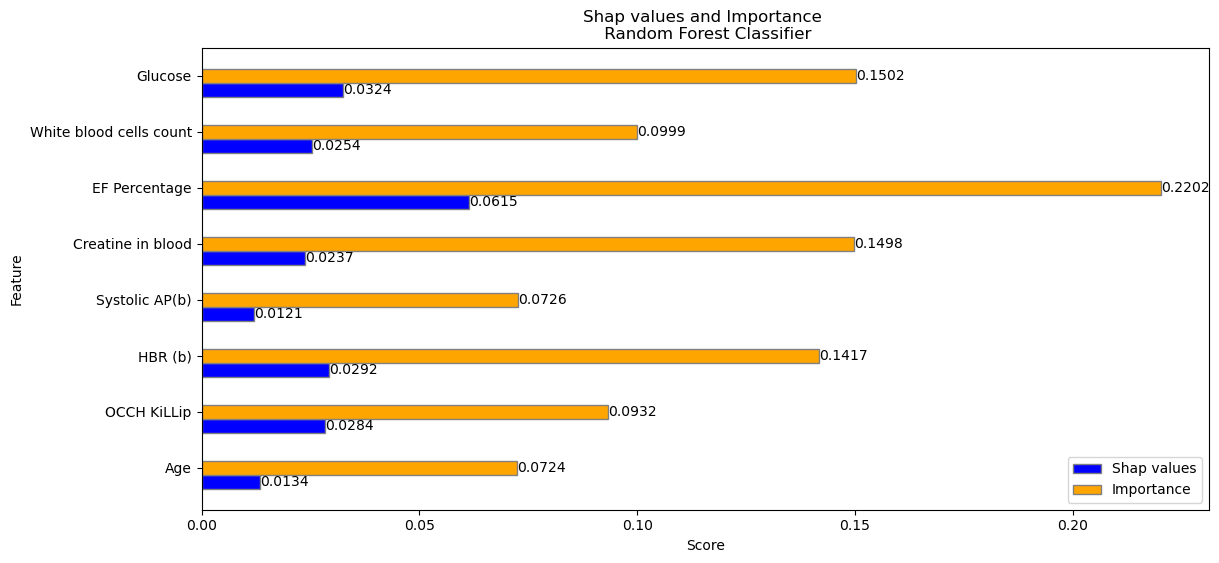

In [22]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_importance', 
             label1='Shap values', 
             label2='Importance', 
             title='Shap values and Importance \n Random Forest Classifier',
             num_digits=4)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


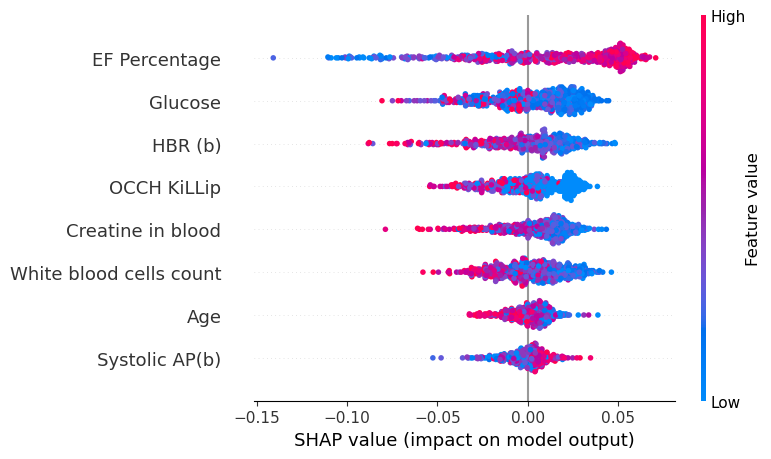

In [23]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)